# Build a taxi driving agent in a post-apocalyptic world using Reinforcement Learning | Machine Learning from Scratch

## Pick up passengers, avoid danger and drop them off at a specified location. Build an agent and solve the problem using Q-learning:

### 1- The environment gives your agent a state
### 2- Your agent chooses an action (from a set of possible ones)
### 3- The environment gives a reward along with a new state
### 4- Continue until the goal or other condition is met

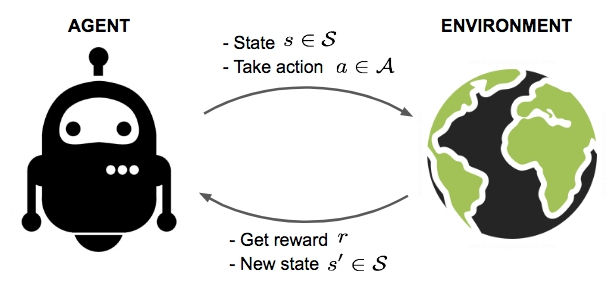

In [1]:
from PIL import Image
img = Image.open(r"C:\\Users\\alvesd\\OneDrive - smmt.co.uk\\Desktop\\Diego_work_folder\python\\22_Ai_Example\\Example.jpg")
img

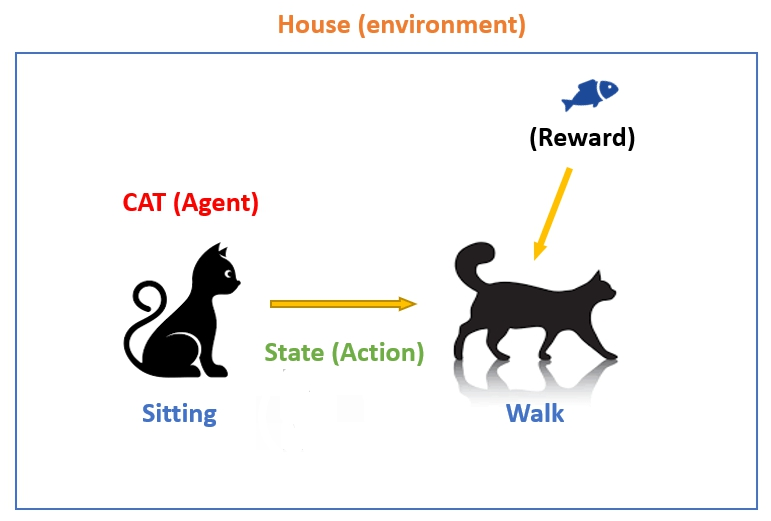

In [2]:
from PIL import Image
img = Image.open(r"C:\\Users\\alvesd\\OneDrive - smmt.co.uk\\Desktop\\Diego_work_folder\python\\22_Ai_Example\\Example_1.jpg")
img

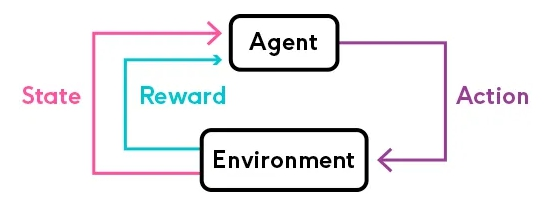

In [3]:
from PIL import Image
img = Image.open(r"C:\\Users\\alvesd\\OneDrive - smmt.co.uk\\Desktop\\Diego_work_folder\python\\22_Ai_Example\\Example_2.jpg")
img


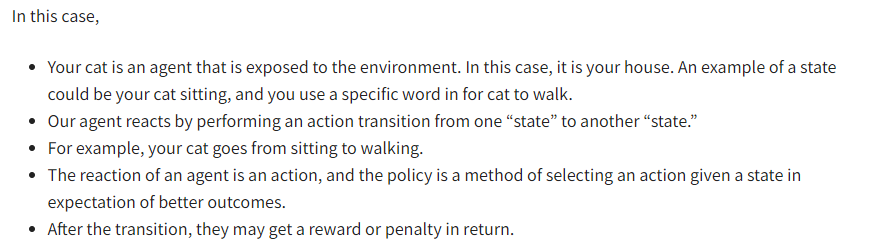

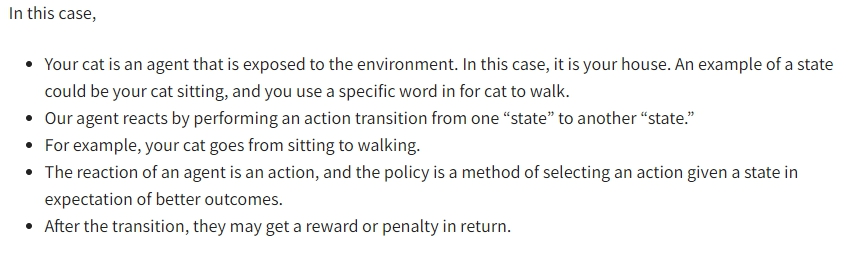

In [4]:
from PIL import Image
img = Image.open(r"C:\\Users\\alvesd\\OneDrive - smmt.co.uk\\Desktop\\Diego_work_folder\python\\22_Ai_Example\\Example_4.jpg")
img

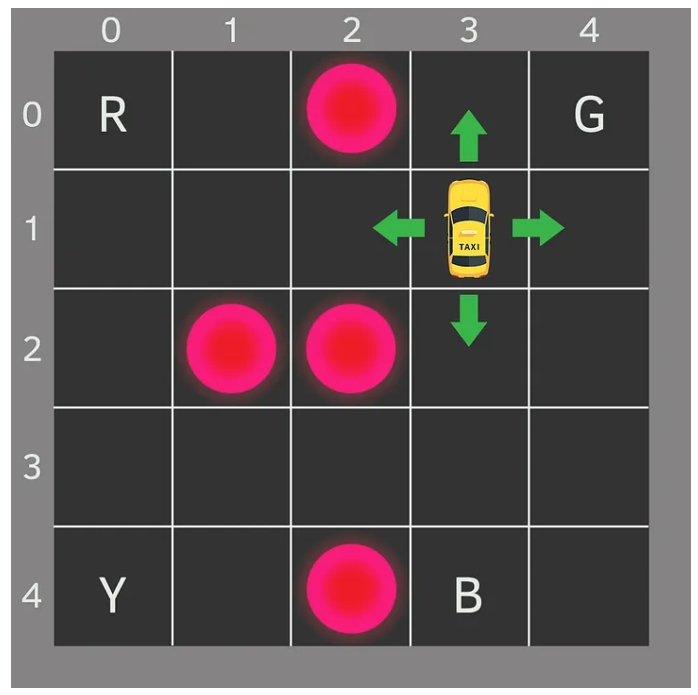

In [5]:
from PIL import Image
img = Image.open(r"C:\\Users\\alvesd\\OneDrive - smmt.co.uk\\Desktop\\Diego_work_folder\python\\22_Ai_Example\\Example_3.jpg")
img

# Reinforcement Learning

Let's describe the "taxi problem". We want to build a self-driving taxi that can pick up passengers at one of a set of fixed locations, drop them off at another location, and get there in the quickest amount of time while avoiding obstacles.

The AI Gym lets us create this environment quickly: 

In [6]:
import gym
import random

random.seed(1234)

streets = gym.make("Taxi-v3").env #New versions keep getting released; if -v3 doesn't work, try -v2 or -v4
streets.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


Let's break down what we're seeing here:

-  R, G, B, and Y are pickup or dropoff locations.
-  The BLUE letter indicates where we need to pick someone up from.
-  The MAGENTA letter indicates where that passenger wants to go to.
-  The solid lines represent walls that the taxi cannot cross.
-  The filled rectangle represents the taxi itself - it's yellow when empty, and green when carrying a passenger.

Our little world here, which we've called "streets", is a 5x5 grid. The state of this world at any time can be defined by:

-  Where the taxi is (one of 5x5 = 25 locations)
-  What the current destination is (4 possibilities)
-  Where the passenger is (5 possibilities: at one of the destinations, or inside the taxi)

So there are a total of 25 x 4 x 5 = 500 possible states that describe our world.

For each state, there are six possible actions:

-  Move South, East, North, or West
-  Pickup a passenger
-  Drop off a passenger

Q-Learning will take place using the following rewards and penalties at each state:

-  A successfull drop-off yields +20 points
-  Every time step taken while driving a passenger yields a -1 point penalty
-  Picking up or dropping off at an illegal location yields a -10 point penalty

Moving across a wall just isn't allowed at all.

Let's define an initial state, with the taxi at location (2, 3), the passenger at pickup location 2, and the destination at location 0:

In [7]:
initial_state = streets.encode(2, 3, 2, 0)

streets.s = initial_state

streets.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


Let's examine the reward table for this initial state:

In [8]:
streets.P[initial_state]

{0: [(1.0, 368, -1, False)],
 1: [(1.0, 168, -1, False)],
 2: [(1.0, 288, -1, False)],
 3: [(1.0, 248, -1, False)],
 4: [(1.0, 268, -10, False)],
 5: [(1.0, 268, -10, False)]}

Here's how to interpret this - each row corresponds to a potential action at this state: move South, North, East, or West, pickup, or dropoff. The four values in each row are the probability assigned to that action, the next state that results from that action, the reward for that action, and whether that action indicates a successful dropoff took place. 

So for example, moving North from this state would put us into state number 368, incur a penalty of -1 for taking up time, and does not result in a successful dropoff.

So, let's do Q-learning! First we need to train our model. At a high level, we'll train over 10,000 simulated taxi runs. For each run, we'll step through time, with a 10% chance at each step of making a random, exploratory step instead of using the learned Q values to guide our actions.

In [9]:
import numpy as np

q_table = np.zeros([streets.observation_space.n, streets.action_space.n])

learning_rate = 0.1
discount_factor = 0.6
exploration = 0.1
epochs = 10000

#An epoch in machine learning means one complete pass of the training dataset through the algorithm. This epoch's number is an important hyperparameter for the #algorithm. It specifies the number of epochs or complete passes of the entire training dataset passing through the training or learning process of the algorithm.

for taxi_run in range(epochs):
    state = streets.reset()
    done = False
    
    while not done:
        random_value = random.uniform(0, 1)
        if (random_value < exploration):
            action = streets.action_space.sample() # Explore a random action
        else:
            action = np.argmax(q_table[state]) # Use the action with the highest q-value
            
        next_state, reward, done, info = streets.step(action)
        
        prev_q = q_table[state, action]
        next_max_q = np.max(q_table[next_state])
        new_q = (1 - learning_rate) * prev_q + learning_rate * (reward + discount_factor * next_max_q)
        q_table[state, action] = new_q
        
        state = next_state
        
        

So now we have a table of Q-values that can be quickly used to determine the optimal next step for any given state! Let's check the table for our initial state above:

In [10]:
q_table[initial_state]

array([-2.42205024, -2.41397516, -2.41009974, -2.3639511 , -8.88624988,
       -8.39981416])

The lowest q-value here corresponds to the action "go West", which makes sense - that's the most direct route toward our destination from that point. It seems to work! Let's see it in action!

In [11]:
from IPython.display import clear_output
from time import sleep

for tripnum in range(1, 11):
    state = streets.reset()
   
    done = False
    trip_length = 0
    
    while not done and trip_length < 20:
        action = np.argmax(q_table[state])
        next_state, reward, done, info = streets.step(action)
        clear_output(wait=True)
        print("Trip number " + str(tripnum) + " Step " + str(trip_length))
        print(streets.render(mode='ansi'))
        sleep(.5)
        state = next_state
        trip_length += 1
        
    sleep(2)
    

Trip number 10 Step 13
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


## Your Challenge

Modify the block above to keep track of the total time steps, and use that as a metric as to how good our Q-learning system is. You might want to increase the number of simulated trips, and remove the sleep() calls to allow you to run over more samples.

Now, try experimenting with the hyperparameters. How low can the number of epochs go before our model starts to suffer? Can you come up with better learning rates, discount factors, or exploration factors to make the training more efficient? The exploration vs. exploitation rate in particular is interesting to experiment with.